In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# maximize row width to see tx ids
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', None)

# Load ohm swap datasets and preprocess

In [3]:
# load datasets
ohmv1_df = pd.read_csv('ohmv1_df_9.21.22.csv')  
ohmv2_df = pd.read_csv('ohmv2_df_9.21.22.csv')  

In [4]:
# set index to datetime
ohmv1_df = ohmv1_df.set_index('pair_swaps_datetime')
ohmv2_df = ohmv2_df.set_index('pair_swaps_datetime')

# convert datetime from string to datetime
ohmv1_df.index = pd.to_datetime(ohmv1_df.index)
ohmv2_df.index = pd.to_datetime(ohmv2_df.index)

# cut off dataframes to account for migration periods
ohmv1_df = ohmv1_df[ohmv1_df.index < '2022-02-01 00:0:0'] # Cutoff was 12.18.22, but some smaller batch liquidity moved since then
ohmv2_df = ohmv2_df[ohmv2_df.index < '2022-09-01 00:0:0'] # before 8.1.22 (migration to balancer has been DCA/ongoing)

In [5]:
# combine datasets
ohm_dfs = [ohmv1_df, ohmv2_df]
ohm_lp_df = pd.concat(ohm_dfs)

# reverse index from asc to desc
ohm_lp_df = ohm_lp_df.iloc[::-1]
ohm_lp_df = ohm_lp_df.sort_index()

In [6]:
# add ohm price column. 
# NOTE - THIS IS NOT ACCURATE, FOUND ERRORS. DO NOT USE!
ohm_lp_df['ohm_price'] = ohm_lp_df['pair_swaps_amountUSD'] / (ohm_lp_df['pair_swaps_amount0In'] + ohm_lp_df['pair_swaps_amount0Out']) # gives errors because amountUSD is wrong
# ohm_lp_df['ohm_price'] = abs((ohm_lp_df['pair_swaps_amount1Out'] - ohm_lp_df['pair_swaps_amount1In']) / (ohm_lp_df['pair_swaps_amount0Out'] - ohm_lp_df['pair_swaps_amount0In']))

In [7]:
# add a buy/sell boolean column
ohm_lp_df['buy'] = ohm_lp_df.pair_swaps_amount0In == 0 # If amount0In is 0, it's a buy because you're getting ohm out. True = Buy

In [8]:
def ohm_lp_stats(df: pd.DataFrame):
    ''''
    This function requires sushiswap lp dataframe argument.
    Retrieve basic stats from the dataset. 
    Checks unique sender address and recipient (to) address count, swap count, vol, and fees.
    '''
    unique_senders = df['pair_swaps_sender'].nunique()
    unique_to = df['pair_swaps_to'].nunique()
    total_swaps = len(df.index)
    total_vol = df['pair_swaps_amountUSD'].sum()
    total_fees = df['pair_swaps_feeRevenue'].sum()
    print(f'unique participants: \nsenders: {unique_senders} \nrecipients (to): {unique_to}')
    print(f'\nswap count: {total_swaps} \ntotal vol: {total_vol:.2f} \nfees: {total_fees:.2f}')

In [9]:
# sellers number is low because it contains router addresses such as sushiswap router.
ohm_lp_stats(ohm_lp_df)

unique participants: 
senders: 557 
recipients (to): 87466

swap count: 473142 
total vol: 12062441357.38 
fees: 30156103.39


# Load flashbots mev list and filter for "active" arbitrageurs

In [10]:
# flashbots mev arbitrageur address list, retrieved from dune dataset
mev_address_df = pd.read_csv('arbitrage_mev_profit_list.csv')  

# update column names
mev_address_df = mev_address_df.rename({'EXPR_1': 'pnl', 'EXPR_2': 'count'}, axis='columns')

# filter arbitrage address "noise" - addresses with few transactions and negative pnl.
# Filter addresses out if they have less than 1k profits and less than 50 transactions.
mev_address_df = mev_address_df[(mev_address_df['pnl'] > 1e3) & (mev_address_df['count'] > 50)]

In [11]:
# extract mev address column to list
mev_address_list = mev_address_df['account_address'].to_list()
print(f'mev arb address count: {len(mev_address_list)}')

mev arb address count: 552


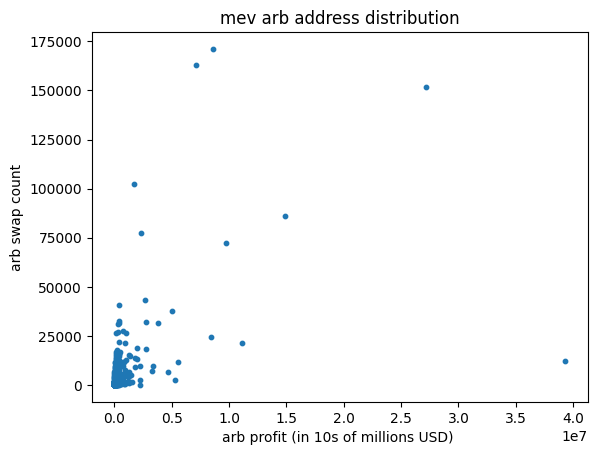

In [12]:
mev_address_df.plot.scatter(x='pnl', y='count', s = 10)
plt.title('mev arb address distribution')
plt.xlabel("arb profit (in 10s of millions USD) ")
plt.ylabel("arb swap count")
plt.show();

In [13]:
# create filters on sender/to columns
mev_sender_filter = ohm_lp_df['pair_swaps_sender'].isin(mev_address_list)
mev_to_filter = ohm_lp_df['pair_swaps_to'].isin(mev_address_list)

In [14]:
# this is redundant, but let's me iterate faster incase I break things
mev_df = ohm_lp_df

In [15]:
# add 2 boolean columns. If sender is mev, then True. If to is mev, then True. Else False. 
mev_df['mev_sender'] = mev_sender_filter
mev_df['mev_to'] = mev_to_filter

# convert booleans into ints
mev_df['mev_sender'] = mev_df['mev_sender'].astype(int)
mev_df['mev_to'] = mev_df['mev_to'].astype(int)

## Boxplot of MEV and non-MEV swaps

In [16]:
mev_swap_df = mev_df.loc[mev_df['mev_sender'] == 0] # 0 = True = MEV
non_mev_swap_df = mev_df.loc[mev_df['mev_sender'] == 1] # 1 = False = Non-MEV

print(f'mev df size: {len(mev_swap_df)}, non-mev df size: {len(non_mev_swap_df)}') # many more mev swap dfs

mev df size: 386396, non-mev df size: 86746


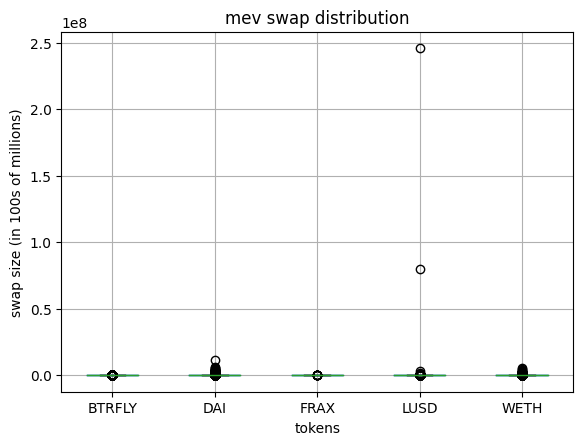

In [17]:
# looks like there is some bugginess in swap data, there shouldn't be swaps with a size of 100m
boxplot = mev_swap_df.boxplot(column=['pair_swaps_amountUSD'], by=['pair_swaps_pair_token1_symbol'])
plt.xlabel('tokens')
plt.ylabel('swap size (in 100s of millions)')
title_boxplot = 'mev swap distribution'
plt.title( title_boxplot )
plt.suptitle('') # suppress bpandas boxplot default title
plt.show()

In [18]:
# filter based on 97.5th quantile
mev_swap_quantile = mev_swap_df[mev_swap_df.pair_swaps_amountUSD < mev_swap_df.pair_swaps_amountUSD.quantile(.99999)]

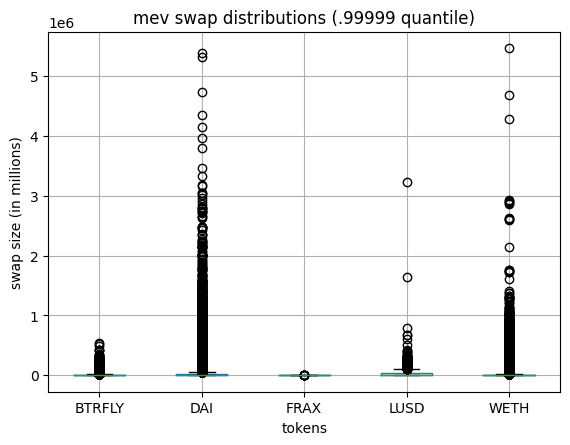

In [19]:
boxplot = mev_swap_quantile.boxplot(column=['pair_swaps_amountUSD'], by=['pair_swaps_pair_token1_symbol'])
plt.xlabel('tokens')
plt.ylabel('swap size (in millions)')
title_boxplot = 'mev swap distributions (.99999 quantile)'
plt.title( title_boxplot )
plt.suptitle('') # suppress bpandas boxplot default title
plt.show()

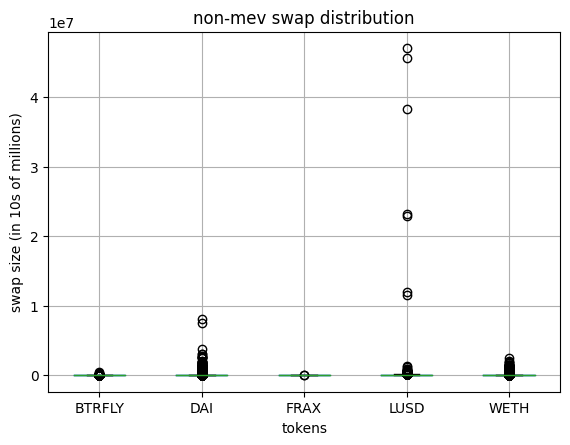

In [20]:
#plausible to see 40-50 million dollar swap sizes oN LUSD, but again could be a bug.
boxplot = non_mev_swap_df.boxplot(column=['pair_swaps_amountUSD'], by=['pair_swaps_pair_token1_symbol'])
plt.xlabel('tokens')
plt.ylabel('swap size (in 10s of millions)')
title_boxplot = 'non-mev swap distribution'
plt.title( title_boxplot )
plt.suptitle('') # suppress bpandas boxplot default title
plt.show()

In [21]:
# filter based on 97.5th quantile
non_mev_swap_quantile = non_mev_swap_df[non_mev_swap_df.pair_swaps_amountUSD < non_mev_swap_df.pair_swaps_amountUSD.quantile(.9999)]

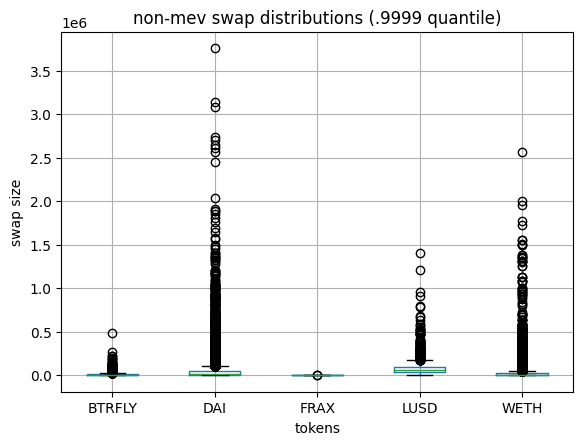

In [22]:
boxplot = non_mev_swap_quantile.boxplot(column=['pair_swaps_amountUSD'], by=['pair_swaps_pair_token1_symbol'])
plt.xlabel('tokens')
plt.ylabel('swap size')
title_boxplot = 'non-mev swap distributions (.9999 quantile)'
plt.title( title_boxplot )
plt.suptitle('') # suppress bpandas boxplot default title
plt.show()

# Aggregate volume breakdown between MEV and non-MEV

In [23]:
# group by mmev sender values, count swap amount USD
mev_agg_df_vol = mev_df.groupby(['mev_sender', 'pair_swaps_pair_token1_symbol'])['pair_swaps_amountUSD'].sum()

# reset index to make easier to work with
mev_agg_df_vol = mev_agg_df_vol.reset_index('mev_sender')

In [24]:
mev_agg_df_vol

,mev_sender,pair_swaps_amountUSD
pair_swaps_pair_token1_symbol,,
BTRFLY,0,3.670704e+08
DAI,0,5.941560e+09
FRAX,0,9.949111e+03
LUSD,0,4.188352e+08
WETH,0,2.401928e+09
BTRFLY,1,1.025698e+08
DAI,1,1.465034e+09
FRAX,1,2.276137e+04
LUSD,1,4.893852e+08


In [26]:
# seperate columns into two dfs
mev_vol_df = mev_agg_df_vol.loc[mev_agg_df_vol['mev_sender'] == 0] # 0 = True = MEV
non_mev_vol_df = mev_agg_df_vol.loc[mev_agg_df_vol['mev_sender'] == 1] # 1 = False = Non-MEV

# combine mev and non-mev vol dfs
combined_vol_df = mev_vol_df
combined_vol_df['non_mev_pair_swaps_amountUSD'] = non_mev_vol_df['pair_swaps_amountUSD']

# drop mev_sender column
combined_vol_df = combined_vol_df.drop('mev_sender', axis=1)

# rename columns for better plotting visualization
combined_vol_df = combined_vol_df.rename(columns={"pair_swaps_amountUSD": "mev swap vol", "non_mev_pair_swaps_amountUSD": "non-mev swap vol"})

/tmp/ipykernel_80071/174661252.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_vol_df['non_mev_pair_swaps_amountUSD'] = non_mev_vol_df['pair_swaps_amountUSD']


Text(0.5, 1.0, 'swap vol')

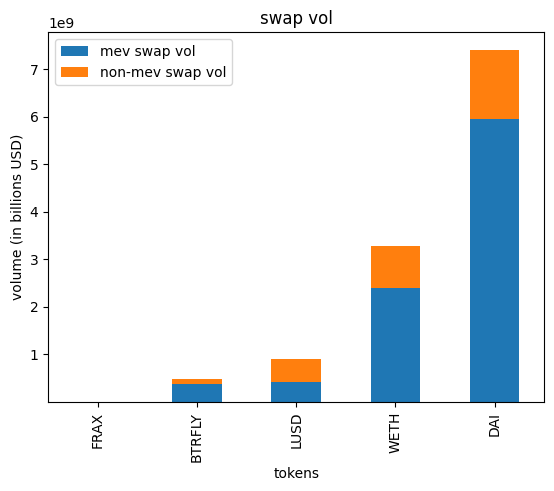

In [36]:
combined_vol_df.sort_values('non-mev swap vol').plot.bar(stacked=True, legend=True)
plt.xlabel("tokens")
plt.ylabel("volume (in billions USD)")
plt.title("swap vol")

# Swap count for MEV and non-MEV addresses

In [28]:
# total value counts
mev_df['mev_sender'].value_counts()

0    386396
1     86746
Name: mev_sender, dtype: int64

In [29]:
# multi_index_df = mev_df.groupby('pair_swaps_pair_token1_symbol')['mev_sender'].value_counts()
multi_index_df = mev_df.groupby('mev_sender')['pair_swaps_pair_token1_symbol'].value_counts()

# reset index to make easier to work with
multi_index_df = multi_index_df.reset_index('mev_sender')

# column and index were same names, changed column name.
multi_index_df = multi_index_df.rename({'pair_swaps_pair_token1_symbol': 'swap_count'}, axis='columns')

# seperate the count columns 
mev_count_df = multi_index_df.loc[multi_index_df['mev_sender'] == 0]
non_mev_count_df = multi_index_df.loc[multi_index_df['mev_sender'] == 1]

mevdf3 = mev_count_df
mevdf3['non_mev_swap_count'] = non_mev_count_df['swap_count']

# drop mev_sender column
mevdf3 = mevdf3.drop('mev_sender', axis=1)

# rename columns for better plotting visualization
mevdf3 = mevdf3.rename(columns={"swap_count": "mev swap count", "non_mev_swap_count": "non-mev swap count"})

/tmp/ipykernel_80071/3401891844.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mevdf3['non_mev_swap_count'] = non_mev_count_df['swap_count']


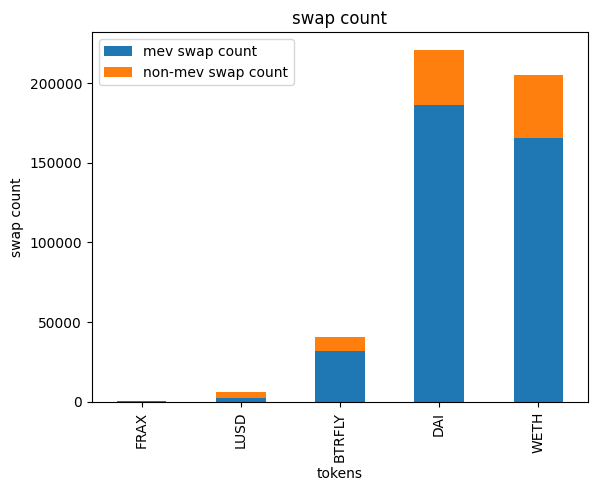

In [37]:
mevdf3.sort_values('non-mev swap count').plot.bar(stacked=True, legend=True)
plt.xlabel("tokens")
plt.ylabel("swap count")
plt.title("swap count")
plt.show()

# Buy/Sell Flows of MEV and non-MEV addresses

In [31]:
# group by "buy" to add mev buy/sell flow analysis
mev_buy_vol_df = mev_df.groupby(['mev_sender', 'pair_swaps_pair_token1_symbol', 'buy'])['pair_swaps_amountUSD'].sum() # mev_sender = mev sent == true or false
mev_buy_vol_df = mev_buy_vol_df.reset_index(['mev_sender', 'buy'])

# seperate mev from non mev buy/sell flows
mev_buy_sell_df = mev_buy_vol_df[mev_buy_vol_df['mev_sender'] == 0]
non_mev_buy_sell_df = mev_buy_vol_df[mev_buy_vol_df['mev_sender'] == 1]

In [32]:
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

In [33]:
sell_c = mpatches.Patch(color='r', label='sell flow')
buy_c = mpatches.Patch(color='g', label='buy flow')

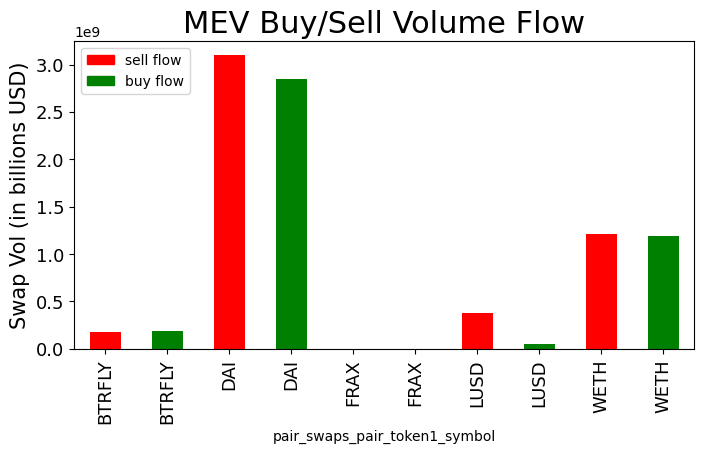

In [34]:
ax = mev_buy_sell_df['pair_swaps_amountUSD'].plot(kind='bar', figsize=(8,4), color=['r', 'g'],  fontsize=13, legend=True)
ax.set_title("MEV Buy/Sell Volume Flow", fontsize=22)
ax.set_ylabel("Swap Vol (in billions USD)", fontsize=15)
plt.legend(handles=[sell_c, buy_c], loc=2)
plt.show()

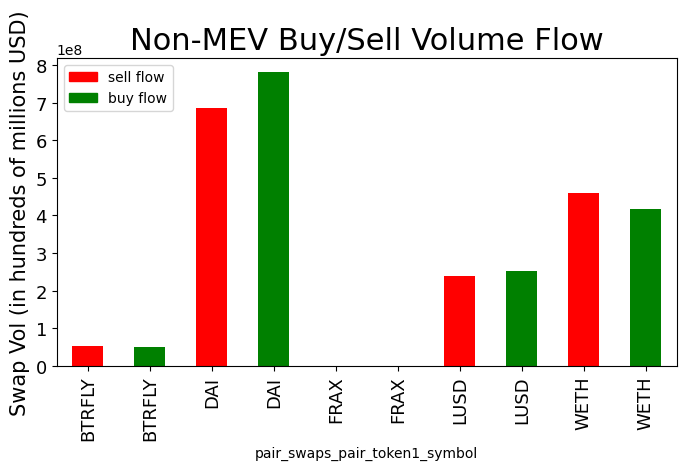

In [35]:
ax = non_mev_buy_sell_df['pair_swaps_amountUSD'].plot(kind='bar', figsize=(8,4), color=['r', 'g'],  fontsize=13, legend=True)
ax.set_title("Non-MEV Buy/Sell Volume Flow", fontsize=22)
ax.set_ylabel("Swap Vol (in hundreds of millions USD)", fontsize=15)
plt.legend(handles=[sell_c, buy_c], loc=2)
plt.show()